## Overview
I came up with three rough ideas what to do with the data
1. Idea: model the data as markov process (only last state determines the following one)
2. Idea: usage of unsupervised anomaly detection based on the data of two consecutive time stamps
3. Idea: usage of knowledge on "normal" behaviour to label some data set and use supervised learning (good with more context information)

## Idea 1
There are some "states" in the time series with typical transitions.


| State     | Specification           | Typical transition |
| --- | --- | --- |
| 1 "start" | time interval irrelevant<br />hT ~ cT+2 °C| 1->2<br />1->4|
| 2 "hc" | heating hT~30-35 °C <br />cT ~ 15 °C| 2->3<br />2->1<br />2->4|
| 2 "h" | heating hT~30-35 °C <br />cT  is NaN| 3->3<br />3->1<br />3->4|
| 4 "anomaly" | none | all|

This could be modelled by a hidden-markov-process with non-Gaussian emission distributions. There are 2 challenges:
- How to deal with NaN-values? We could set them to a fix value
- How to deal with the time-distribution? We could cap the time intervals to some value or go to a log-scale in time.

<div class="alert alert-block alert-info">
<b>Note:</b> This idea might reproduce the data very well and identify anomalies. However, the effort was beyond the scope of this coding challenge.
</div>

## Idea 2
According to the previous thoughts (idea 1), all the necessary information is given by the current state and the previous state. We can combine the information at a time (time interval, heating temperature, cooling temperature) with the values of the previous time for unsupervised training (e.g. Isolation Forest).

In [151]:
import pandas as pd

df = pd.read_csv("../../data/" + "MICDEV001_2019-04-13_2020-01-24.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

df.head()

,datetime,heating_temperature,cooling_temperature
0,2019-04-13 17:51:16,33.3,15.0
1,2019-04-13 18:51:18,34.0,NaN
2,2019-04-13 19:51:20,33.8,NaN
3,2019-04-13 20:51:21,34.2,NaN
4,2019-04-13 21:51:23,34.5,NaN


- Convert data to delta-T 
- Duplicate & shift data by 1
- Replace NaN-values and large delta-T

In [152]:
if_df = df.copy()

maxVal = 20000 # set a maximum value for the time interval
hTnan = 51     # replace NaN-value with constant far from distribution
cTnan = -11    # replace NaN-value with constant far from distribution


if_df['heating_temperature'] = if_df['heating_temperature'].fillna(hTnan)
if_df['cooling_temperature'] = if_df['cooling_temperature'].fillna(-11)

if_df['delta_T'] = if_df["datetime"].diff() / np.timedelta64(1, 's')
if_df['delta_T'] = if_df['delta_T'].fillna(maxVal)

if_df["hT_prev"] = if_df["heating_temperature"].shift(1)
if_df["cT_prev"] = if_df["cooling_temperature"].shift(1)
if_df["delta_T_prev"] = if_df['delta_T'].shift(1)

if_df['hT_prev'] = if_df['hT_prev'].fillna(hTnan)
if_df['cT_prev'] = if_df['cT_prev'].fillna(cTnan)
if_df['delta_T_prev'] = if_df['delta_T_prev'].fillna(maxVal)

if_df['delta_T'].clip(upper=maxVal)
if_df['delta_T_prev'].clip(upper=maxVal)

if_df.head()

,datetime,heating_temperature,cooling_temperature,delta_T,hT_prev,cT_prev,delta_T_prev
0,2019-04-13 17:51:16,33.3,15.0,20000.0,51.0,-11.0,20000.0
1,2019-04-13 18:51:18,34.0,-11.0,3602.0,33.3,15.0,20000.0
2,2019-04-13 19:51:20,33.8,-11.0,3602.0,34.0,-11.0,3602.0
3,2019-04-13 20:51:21,34.2,-11.0,3601.0,33.8,-11.0,3602.0
4,2019-04-13 21:51:23,34.5,-11.0,3602.0,34.2,-11.0,3601.0


Use all information for fitting

In [167]:
from sklearn.ensemble import IsolationForest

X = if_df[['delta_T','heating_temperature','cooling_temperature','delta_T_prev','hT_prev','cT_prev']].to_numpy()

clf = IsolationForest(random_state=0).fit(X)
result = clf.predict(X)

if_df["result"] = result

if_df.head()

,datetime,heating_temperature,cooling_temperature,delta_T,hT_prev,cT_prev,delta_T_prev,result
0,2019-04-13 17:51:16,33.3,15.0,20000.0,51.0,-11.0,20000.0,-1
1,2019-04-13 18:51:18,34.0,-11.0,3602.0,33.3,15.0,20000.0,1
2,2019-04-13 19:51:20,33.8,-11.0,3602.0,34.0,-11.0,3602.0,1
3,2019-04-13 20:51:21,34.2,-11.0,3601.0,33.8,-11.0,3602.0,1
4,2019-04-13 21:51:23,34.5,-11.0,3602.0,34.2,-11.0,3601.0,1


Plot results

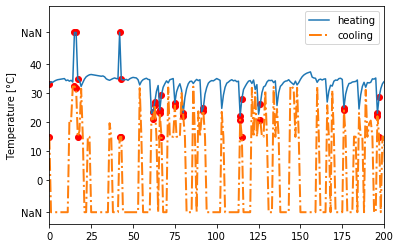

In [195]:
import matplotlib.pyplot as plt
import numpy as np

max_x = 200  #zoom in data

if_df['index'] = df.index

x = if_df['index']
y = if_df['heating_temperature']
plt.plot(x, y, label="heating")
x = if_df['index']
y = if_df['cooling_temperature']
plt.plot(x, y, label="cooling", ls='-.', linewidth=2)

x = if_df[if_df["result"]==-1]['index']
y = if_df[if_df["result"]==-1]['heating_temperature']
plt.scatter(x, y, c='red')

x = if_df[if_df["result"]==-1]['index']
y = if_df[if_df["result"]==-1]['cooling_temperature']
plt.scatter(x, y, c='red')
plt.ylim(-15,60)
plt.xlim(0,max_x)
plt.legend(loc="upper right")
plt.ylabel("Temperature [°C]")

ax = plt.gca()
ax.set_yticks([-11,0,10,20,30,40,51])
ax.set_yticklabels(["NaN",0,10,20,30,40,"NaN"])

plt.show()

Ignore time information

In [166]:
from sklearn.ensemble import IsolationForest

X = if_df[['heating_temperature','cooling_temperature','hT_prev','cT_prev']].to_numpy()

clf = IsolationForest(random_state=0).fit(X)
result = clf.predict(X)

if_df["result"] = result

if_df.head()

,datetime,heating_temperature,cooling_temperature,delta_T,hT_prev,cT_prev,delta_T_prev,result
0,2019-04-13 17:51:16,33.3,15.0,20000.0,51.0,-11.0,20000.0,-1
1,2019-04-13 18:51:18,34.0,-11.0,3602.0,33.3,15.0,20000.0,1
2,2019-04-13 19:51:20,33.8,-11.0,3602.0,34.0,-11.0,3602.0,1
3,2019-04-13 20:51:21,34.2,-11.0,3601.0,33.8,-11.0,3602.0,1
4,2019-04-13 21:51:23,34.5,-11.0,3602.0,34.2,-11.0,3601.0,1


## Idea 3
We use the gathered information to manually annotate the data in a small training set and apply this to future datasets.

This version is useful, when we have additional context and information about the data. E.g. A typical use case could be that a machine is started on an irregular basis (unregular time jumps), there is a fixed heating/cooling temperature, which might be adjusted in other data sets, etc.
Whenever we have such information, we should use it.

In [155]:
import pandas as pd

df = pd.read_csv("../../data/" + "MICDEV001_2019-04-13_2020-01-24.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

df.head()

,datetime,heating_temperature,cooling_temperature
0,2019-04-13 17:51:16,33.3,15.0
1,2019-04-13 18:51:18,34.0,NaN
2,2019-04-13 19:51:20,33.8,NaN
3,2019-04-13 20:51:21,34.2,NaN
4,2019-04-13 21:51:23,34.5,NaN


## Manual annotation
Hard coded proof of principle for state-machine / supervised learning

This is an example of a potential annotation, which uses my assumptions on a normal behaviour (this might be wrong). Since I don't know the context, it is just an example, how it might work. 

In [156]:
import math

df['delta_T'] = df["datetime"].diff() / np.timedelta64(1, 's')

df["state"] = "anomaly"

last_state = ""
for index, row in df.iterrows():
    if index==0:
        df.at[index,"state"] ="hc"
    else:
        dT = row["delta_T"]
        ht = row["heating_temperature"]
        ct = row["cooling_temperature"]
        if (dT<3695 or dT>3605) and abs(ht-ct-2)<2:
            df.at[index,"state"] ="start"
        elif last_state in ("start","hc","h","anomaly") and (dT>=3595 and dT<=3605) and ht>27.5 and (ct>14 and ct<16):
            df.at[index,"state"] ="hc"
        elif last_state=="start":
            df.at[index,"state"] ="anomaly"
        elif last_state in ("hc", "h") and (dT>=3595 and dT<=12*3605) and ht>27.5 and math.isnan(ct):
            df.at[index,"state"] = "h"
        elif last_state in ("hc", "h"):
            df.at[index,"state"] ="anomaly"
    last_state = df.at[index,"state"]
    
pd.set_option('display.max_rows', None)

df.head()

,datetime,heating_temperature,cooling_temperature,delta_T,state
0,2019-04-13 17:51:16,33.3,15.0,NaN,hc
1,2019-04-13 18:51:18,34.0,NaN,3602.0,h
2,2019-04-13 19:51:20,33.8,NaN,3602.0,h
3,2019-04-13 20:51:21,34.2,NaN,3601.0,h
4,2019-04-13 21:51:23,34.5,NaN,3602.0,h


- Convert data to delta-T 
- Duplicate & shift data by 1
- Replace NaN-values and large delta-T

In [157]:
dt_df = df.copy()

maxVal = 20000 # set a maximum value for the time interval
hTnan = 51     # replace NaN-value with constant far from distribution
cTnan = -11    # replace NaN-value with constant far from distribution


dt_df['heating_temperature'] = dt_df['heating_temperature'].fillna(hTnan)
dt_df['cooling_temperature'] = dt_df['cooling_temperature'].fillna(-11)

dt_df['delta_T'] = dt_df["datetime"].diff() / np.timedelta64(1, 's')
dt_df['delta_T'] = dt_df['delta_T'].fillna(maxVal)

dt_df["hT_prev"] = dt_df["heating_temperature"].shift(1)
dt_df["cT_prev"] = dt_df["cooling_temperature"].shift(1)
dt_df["delta_T_prev"] = dt_df['delta_T'].shift(1)

dt_df['hT_prev'] = dt_df['hT_prev'].fillna(hTnan)
dt_df['cT_prev'] = dt_df['cT_prev'].fillna(cTnan)
dt_df['delta_T_prev'] = dt_df['delta_T_prev'].fillna(maxVal)

dt_df['delta_T'].clip(upper=maxVal)
dt_df['delta_T_prev'].clip(upper=maxVal)

dt_df.head()

,datetime,heating_temperature,cooling_temperature,delta_T,state,hT_prev,cT_prev,delta_T_prev
0,2019-04-13 17:51:16,33.3,15.0,20000.0,hc,51.0,-11.0,20000.0
1,2019-04-13 18:51:18,34.0,-11.0,3602.0,h,33.3,15.0,20000.0
2,2019-04-13 19:51:20,33.8,-11.0,3602.0,h,34.0,-11.0,3602.0
3,2019-04-13 20:51:21,34.2,-11.0,3601.0,h,33.8,-11.0,3602.0
4,2019-04-13 21:51:23,34.5,-11.0,3602.0,h,34.2,-11.0,3601.0


Train decision tree

In [158]:
from sklearn.tree import DecisionTreeClassifier


X = dt_df[['delta_T','heating_temperature','cooling_temperature','delta_T_prev','hT_prev','cT_prev']].to_numpy()

y = dt_df['state'].to_numpy()

split = round(0.2*len(X))
X_train = X[split:]
y_train = y[split:]
X_test = X[:split]
y_test = y[:split]

clf = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

result = clf.predict(X_test)

In [159]:
df_actual = pd.DataFrame(y_test, columns=["Actual"])
df_predict = pd.DataFrame(result, columns=["Predicted"])
confusion_matrix = pd.crosstab(df_actual['Actual'], df_predict['Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,anomaly,h,hc,start
Actual,,,,
anomaly,8,1,3,0
h,19,63,0,0
hc,1,0,26,0
start,1,0,0,21


In [165]:
import plotly.express as px

fig = px.scatter(df, y=["heating_temperature"], color="state", color_discrete_sequence=['#636EFA', '#00CC96', '#EF553B', '#AB63FA'])
fig.show()
fig = px.scatter(df, y=["cooling_temperature"], color="state", color_discrete_sequence=['#636EFA', '#00CC96', '#EF553B', '#AB63FA'])
fig.show()